# Test align_curves
### Imports

In [1]:
library(ggplot2)
library(dplyr)
library(tikzDevice)
library(viridis)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite



In [2]:
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)

# Display plots in smaller size
options(repr.plot.width=10, repr.plot.height=6)

### Define theme

In [3]:
theme_thesis <- function(){ 
    theme_bw() %+replace%    #replace elements we want to change
    theme()
}

### Prepare Digits3 Data

In [4]:
library(elasticproc2d)
source("../scripts/load_datasets.R")

set.seed(18)
data_curves <- curves.digit3(rotate=TRUE, scale=TRUE, center=FALSE)

knots <- seq(0, 1, length = 13)

In [5]:
mean1 <- compute_elastic_proc2d_mean(data_curves, knots = knots, type = "smooth", penalty = 2, pfit_method = "linear")
mean2 <- compute_elastic_proc2d_mean(data_curves, knots = knots, type = "smooth", penalty = 2, pfit_method = "smooth")

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis coefficients”
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
“there is *no* information about some basis

#### Smooth observed curves

In [6]:
pfits.smooth <- lapply(seq_along(mean2$data_curves), function(j){
  knots <- mean2$knots
  type <- mean2$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean2$fit$pfit_coefs[[j]]
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
  curve <- elasdics::get_points_from_srv(srv)
  center_curve(curve)
})[seq(1,10)]

pfits <- lapply(seq_along(mean2$data_curves), function(j){
    center_curve(mean2$data_curves[[j]])/elasticproc2d:::get_polygon_length(data_curves[[j]])
})[seq(1,10)]

#### Fig. 2.3: Procrustes Fit example

In [7]:
set.seed(18)
i = 2
curves <- lapply(seq(2), function(j){
    pfit <- pfits.smooth[[i+j]]
    if(j == 2){
        pfit <- rand_rotate_curve2d(pfit)
        pfit$X1 <- pfit$X1 + 0.1
        pfit$X2 <- pfit$X2 - 0.05
    }
    pfit$t <- seq(0, 1, length=length(pfit$X1))
    pfit
})
srvs <- lapply(seq(2), function(j){
    pfit <- curves[[j]]
    elasdics::get_srv_from_points(pfit)
})

In [8]:
# Manually compute full Procrustes fit.
srv.pfit <- lapply(seq(2), function(j){
  knots <- mean2$knots
  type <- mean2$type
  t <- seq(0, 1, by=0.01)
  srv.compl <- elasticproc2d:::make_design(t, knots, type) %*% mean2$fit$pfit_coefs[[i+j]]
  if(j==2){
    w <- as.complex( t(Conj(mean2$fit$pfit_coefs[[i+j]])) %*% mean2$fit$gram %*% mean2$fit$pfit_coefs[[i-1+j]] )
    w <- w/sqrt(as.complex( t(Conj(mean2$fit$pfit_coefs[[i+j]])) %*% mean2$fit$gram %*% mean2$fit$pfit_coefs[[i+j]] ))
    w <- w/sqrt(as.complex( t(Conj(mean2$fit$pfit_coefs[[i+j]])) %*% mean2$fit$gram %*% mean2$fit$pfit_coefs[[i+j]] ))
    srv.compl <- w * elasticproc2d:::make_design(t, knots, type) %*%  mean2$fit$pfit_coefs[[i+j]]
  }
  srv <- data.frame("t" = t, "X1" = Re(srv.compl), "X2" = Im(srv.compl))
})
curves.pfit <- lapply(seq(2), function(j){
  curve <- elasdics::get_points_from_srv(srv.pfit[[j]])
  center_curve(curve)
})

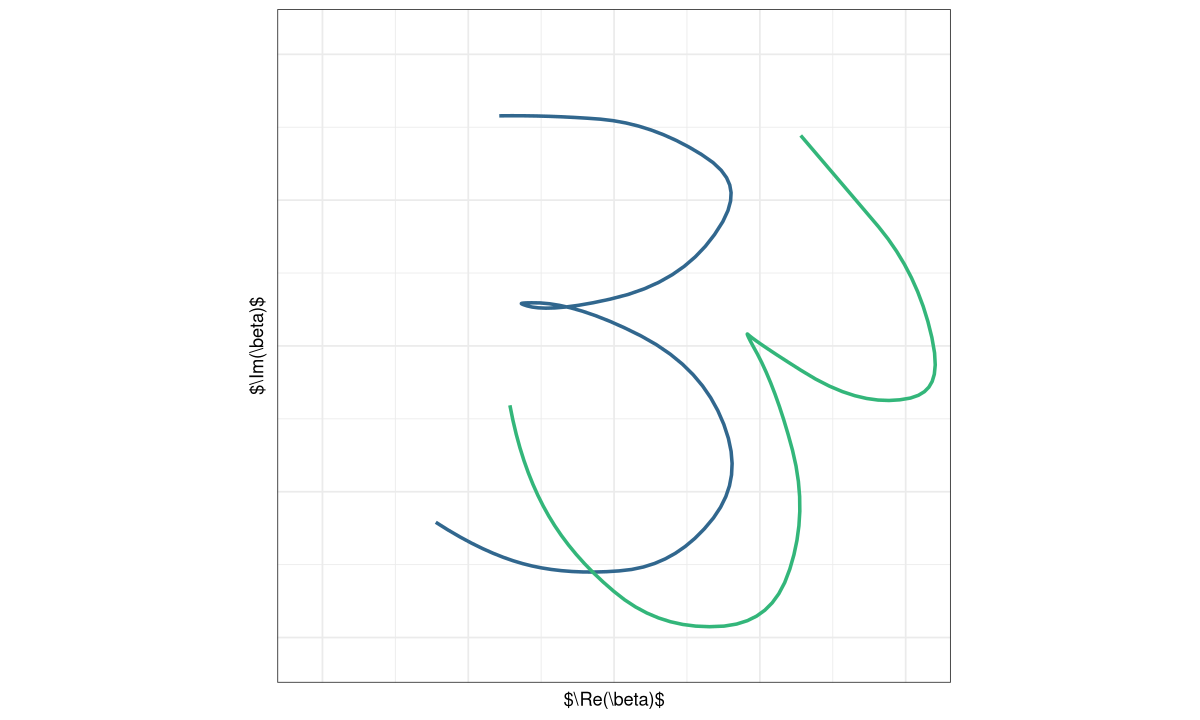

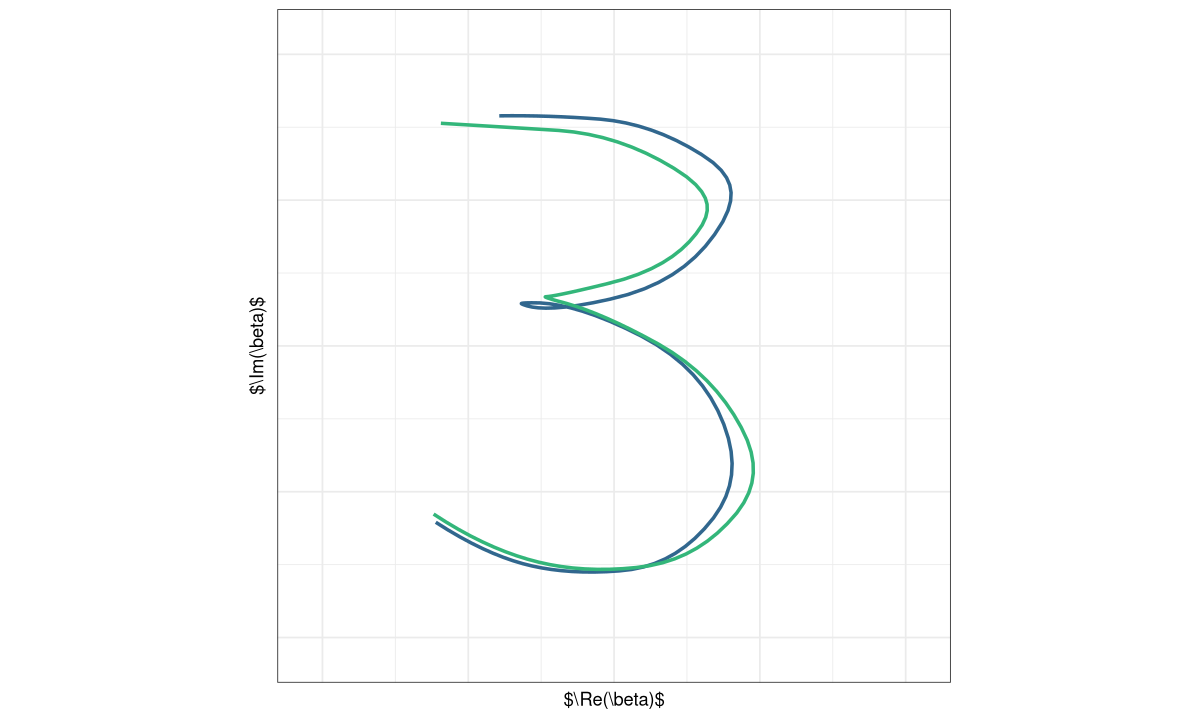

In [9]:
p.curves_match <- ggplot(bind_rows(curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id, color=id), size = 1) +
    labs(x = "$\\Re(\\beta)$", y = "$\\Im(\\beta)$") +
    theme_thesis() +
    scale_colour_viridis_d(begin=0.33, end=0.66, guide="none") +
    theme(axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
            axis.text.x = element_blank(), axis.text.y = element_blank()) +
    coord_fixed(xlim = c(-0.21,0.21), ylim = c(-0.21, 0.21))

plot(p.curves_match)

p.curves_efpfit<- ggplot(bind_rows(curves.pfit, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id, color=id), size = 1) +
    labs(x = "$\\Re(\\beta)$", y = "$\\Im(\\beta)$") +
    theme_thesis() +
    scale_colour_viridis_d(begin=0.33, end=0.66, guide="none") +
    theme(axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
            axis.text.x = element_blank(), axis.text.y = element_blank()) +
    coord_fixed(xlim = c(-0.21,0.21), ylim = c(-0.21, 0.21))

plot(p.curves_efpfit)

In [10]:
curve1 <- curves[[1]][,-3]
curve2 <- curves[[2]][,-3]

In [40]:
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)

In [37]:
aligned_curves <- elasticproc2d:::align_curves_elastic_proc2d(curve1, curve2, delta = 100, h=0.002)

Warning message in elasticproc2d:::align_curves_elastic_proc2d(curve1, curve2, delta = 100, :
“This function is not fully implemented yet. At the moment only the alignment inside mean calculation works.”
Warning message in elasticproc2d:::align_curves_elastic_proc2d(curve1, curve2, delta = 100, :
“Duplicated points in data curves have been removed!”


[1] "Diff : 1.15050497581004"


In [38]:
aligned_curves_proc2d <- align_curves_proc2d(curve1, curve2, h=0.002)

Warning message in align_curves_proc2d(curve1, curve2, h = 0.002):
“Duplicated points in data curves have been removed!”


In [ ]:
aligned_curves_efproc2d <- elasticproc2d:::align_curves_test(curve1, curve2, delta = 0.15)

Warning message in elasticproc2d:::align_curves_test(curve1, curve2, delta = 0.2):
“This function is not fully implemented yet. At the moment only the alignment inside mean calculation works.”
Warning message in elasticproc2d:::align_curves_test(curve1, curve2, delta = 0.2):
“Duplicated points in data curves have been removed!”


In [ ]:
aligned_curves$w_optim
aligned_curves_proc2d$w_optim
aligned_curves_efproc2d$w_optim

In [44]:
pfit1 <- aligned_curves$pfit_curve1
pfit2 <- aligned_curves$pfit_curve2_aligned
pfit2.new <- aligned_curves_proc2d$pfit_curve2
pfits.new <- bind_rows(list(pfit1,pfit2.new), .id="id")

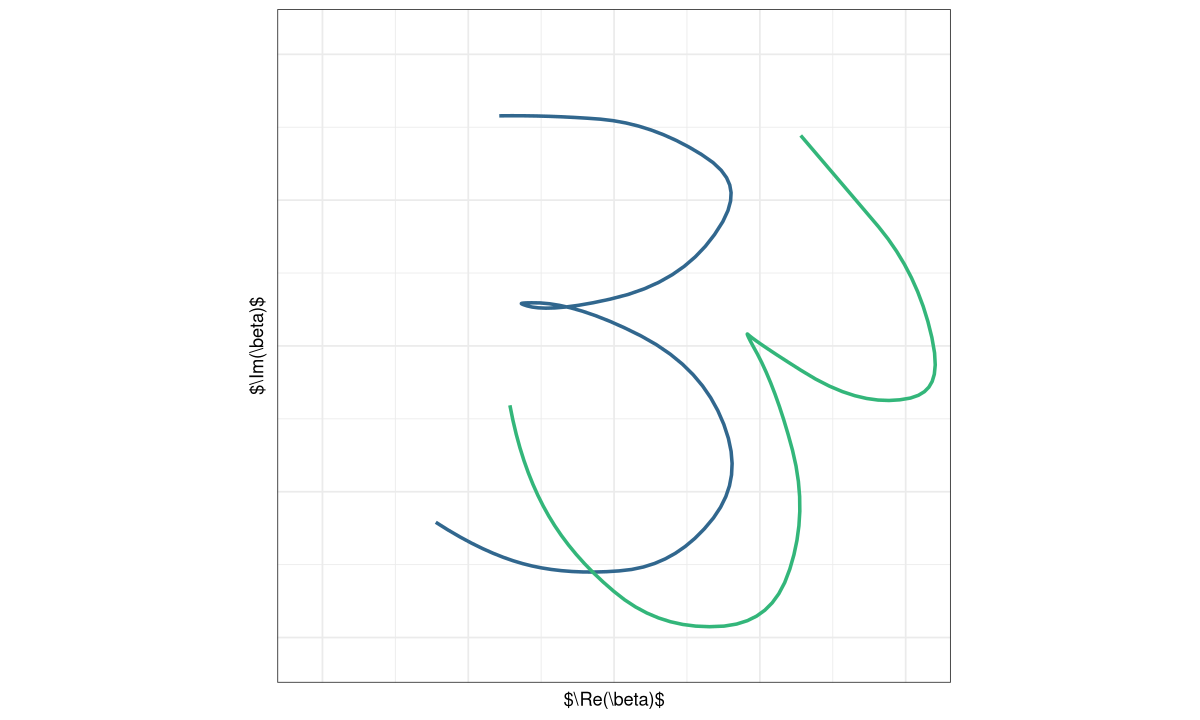

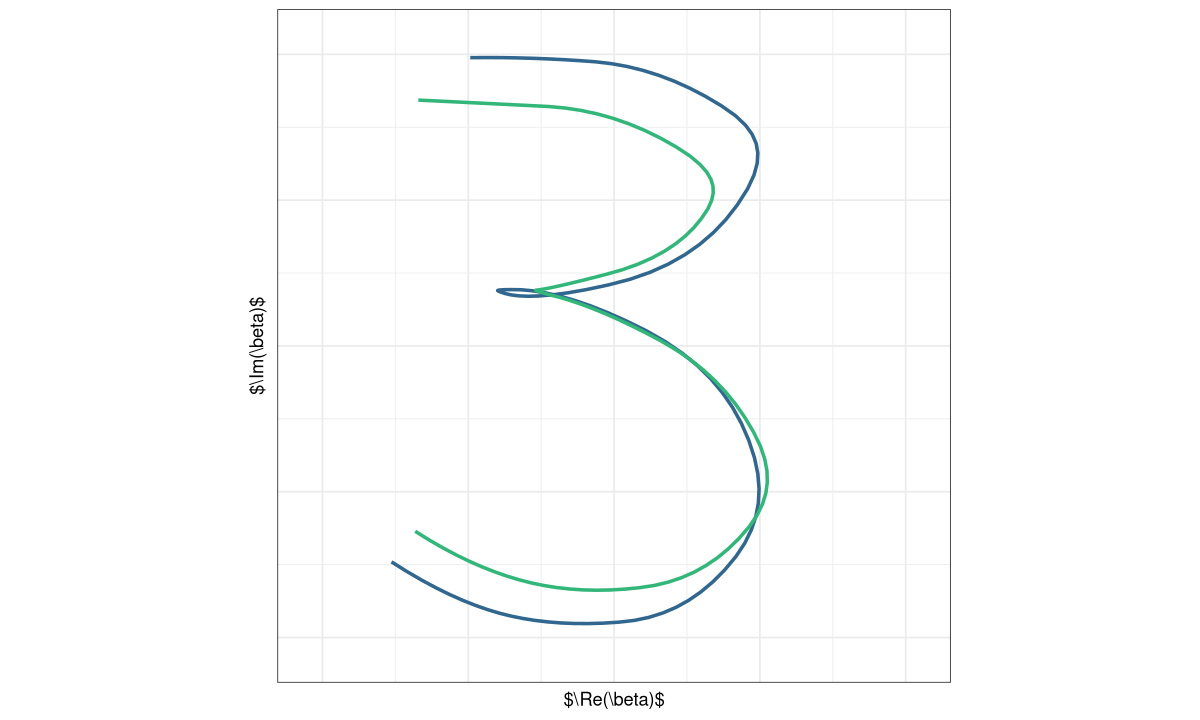

In [45]:
p.curves_match <- ggplot(bind_rows(curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id, color=id), size = 1) +
    labs(x = "$\\Re(\\beta)$", y = "$\\Im(\\beta)$") +
    theme_thesis() +
    scale_colour_viridis_d(begin=0.33, end=0.66, guide="none") +
    theme(axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
            axis.text.x = element_blank(), axis.text.y = element_blank()) +
    coord_fixed(xlim = c(-0.21,0.21), ylim = c(-0.21, 0.21))

plot(p.curves_match)

p.curves_efpfit<- ggplot(pfits.new, aes(x=X1, y=X2)) + 
    geom_path(aes(group=id, color=id), size = 1) +
    labs(x = "$\\Re(\\beta)$", y = "$\\Im(\\beta)$") +
    theme_thesis() +
    scale_colour_viridis_d(begin=0.33, end=0.66, guide="none") +
    theme(axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
            axis.text.x = element_blank(), axis.text.y = element_blank()) +
    coord_fixed(xlim = c(-0.21,0.21), ylim = c(-0.21, 0.21))

plot(p.curves_efpfit)